In [1]:
# -*- coding: utf-8 -*-
#!/usr/bin/env python
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
#import requests
#from bs4 import BeautifulSoup
import re
import os
import sys
from IPython.display import display, HTML
import re
import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import regexp_tokenize

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hema.fullerton\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [54]:
df=pd.read_csv('mapbox_docs_clean.csv')
# df.drop(labels=['Unnamed: 0','CreationDate','answered','answerId','link'],axis=1,inplace=True)
# #using rows which have been answered (i.e) questions which have an AcceptedAnswerId
# df=df[pd.notnull(df['AcceptedAnswerId'])]
df.head(2)

,title,excerpt,site
0,Default callout usage,Use default appearance and interactivity of an...,iOS
1,Create a draggable Marker,Drag the Marker to a new location on a map and...,Mapbox GL JS


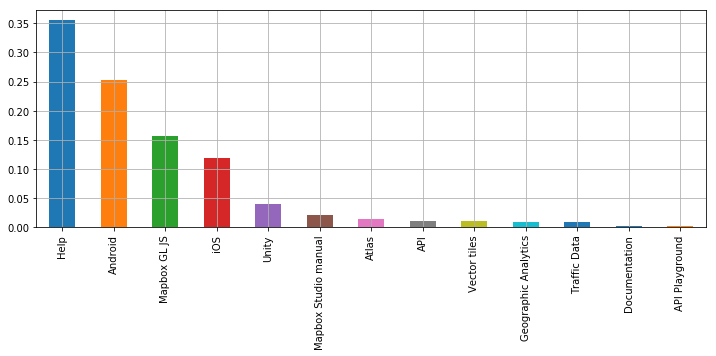

In [55]:
df.site.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(12, 4))

In [56]:
from rake_nltk import Rake
#extracting keyworkds from Subject and Description
def extract_key_words(string):
    r = Rake()
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    
    # extracting the words by passing the text
    r.extract_keywords_from_text(string)

    # getting the dictionary whith key words and their scores
    key_words_dict_scores = r.get_word_degrees()
    returnString=list(key_words_dict_scores.keys())
    returnString=" ".join(str(x) for x in returnString)
    return returnString

In [57]:
#functions for pre-processing text
def cleanString(comment):
    #stopWords = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = tokenize.sent_tokenize(str(comment))
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) ]
                              #if w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list)
    
    return returnString

from rake_nltk import Rake
#extracting keyworkds from Subject and Description
def extract_key_words(string):
    r = Rake()
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    
    # extracting the words by passing the text
    r.extract_keywords_from_text(string)

    # getting the dictionary whith key words and their scores
    key_words_dict_scores = r.get_word_degrees()
    tags=list(key_words_dict_scores.keys())
    
    #removing mapbox from the tag list
    returnString=[]
    for tag in tags:
        if (tag!='mapbox') & (tag!=''):
            returnString.append(tag)
            
    returnString=" ".join(str(x) for x in returnString)
    return returnString

#to remove words not in the dictionary
words = set(nltk.corpus.words.words())

def clean_sent(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(str(sent)) \
     if w.lower() in words or not w.isalpha())


In [58]:
def cleanfinal(String): # removes duplicates in a column.
    return " ".join(set(String.split()))

In [59]:
label_map=dict(zip(np.unique(df.site),range(len(np.unique(df.site)))))
label_map

{'API': 0,
 'API Playground': 1,
 'Android': 2,
 'Atlas': 3,
 'Documentation': 4,
 'Geographic Analytics': 5,
 'Help': 6,
 'Mapbox GL JS': 7,
 'Mapbox Studio manual': 8,
 'Traffic Data': 9,
 'Unity': 10,
 'Vector tiles': 11,
 'iOS': 12}

In [60]:
def get_labels(string):
    return(int(label_map[string]))

In [61]:
df['title_new']=df['title'].apply(cleanString)
df['excerpt_new']=df['excerpt'].apply(extract_key_words)
df["text"] = df["title_new"] + " " +df["excerpt_new"]
df["text_final"]=df["text"].apply(cleanfinal)
df["site_final"]=df["site"]#.apply(get_labels)
df=df.drop(labels=["title_new","excerpt_new","title","excerpt","text"],axis=1)
df=df.drop(labels=["site"],axis=1)

In [62]:
df.head()
#df.to_csv('site_mapping.csv')

,text_final,site_final
0,annotation callout appearance views use usage ...,iOS
1,marker drag populates new location map create ...,Mapbox GL JS
2,extrude fill property for indoor height 3d pai...,Mapbox GL JS
3,js gl code using application need build a guid...,Help
4,street app view learn quickly map create simpl...,Android


In [63]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import metrics

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df["text_final"], df["site_final"], random_state=7,
                                                    test_size=0.2)

In [65]:
svm = LinearSVC()
clf = CalibratedClassifierCV(svm)

In [66]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(activation='relu',alpha=0.05,solver='adam',hidden_layer_sizes=(100,100,100))
clf = CalibratedClassifierCV(nn) 

In [67]:
model=Pipeline([('tfidf', TfidfVectorizer(max_features=300)),
    ('clf', clf)])

In [68]:
model.fit(X_train,y_train)

C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarni

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=300, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...alidation_fraction=0.1, verbose=False, warm_start=False),
            cv='warn', method='sigmoid'))])

In [69]:
pred_train=model.predict(X_train)
print('Training accuracy %s' % accuracy_score(y_train, pred_train))
print('Training F1 score: {}'.format(f1_score(y_train, pred_train, average='weighted')))

Training accuracy 0.9825708061002179
Training F1 score: 0.9798531073410798


C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [70]:
predictions = model.predict(X_test)

In [71]:
print('Testing accuracy %s' % accuracy_score(y_test, predictions))
print('Testing F1 score: {}'.format(f1_score(y_test, predictions, average='weighted')))

Testing accuracy 0.6956521739130435
Testing F1 score: 0.6844492304931127


C:\Users\hema.fullerton\Anaconda3\envs\Keras\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [72]:
predict=["Walking directions go through a river"]
result = model.predict_proba(predict)*100
result

array([[ 1.08022258,  0.53533363, 48.73056831,  1.0774987 ,  0.53533363,
         0.84884559, 11.60415742, 10.52139119,  2.34303776,  1.04499267,
        12.26403517,  1.25410836,  8.160475  ]])

In [73]:
data_pred = pd.DataFrame(columns=['Category', 'probability'])
data_pred['Category'] = model.classes_
data_pred['probability'] = pd.DataFrame((model.predict_proba(predict)*100).T, columns=['probability'])
#data_pred=data_pred[data_pred.Category!='nan']
data_pred.sort_values('probability', ascending = False).head(5)

,Category,probability
2,Android,48.730568
10,Unity,12.264035
6,Help,11.604157
7,Mapbox GL JS,10.521391
12,iOS,8.160475
